### Loading dataframes and packages

In [1]:
import sys, os
os.path.dirname(sys.executable)
sys.path.append('/c4/home/sermare/fusioncharacterization_gliomas/')

In [2]:
from fcg.common_imports import *

In [20]:
import importlib
from fcg import data_utils
importlib.reload(data_utils)
pd.set_option('display.max_columns', None)

In [ ]:
#Arriba with hg38 done May 2024, files that contain the concatenated files are not processed correctly

arriba38 = data_utils.load_data_from_directory(directory='/costellolab/data1/sermare/fusion_hg38/230502024', pattern="*fusions.tsv")
arriba38['file_path'] = arriba38['file_path'].str.replace('_fusions.tsv', '')

#July 14th still running these. However in this paths some directories are correct.  

star38 = data_utils.load_data_from_directory(directory='/costellolab/data1/sermare/fusion_hg38/10072024', pattern="*predictions.tsv", column=-2)

#Add the Annotations for Fusion Gene and Patient Number and SF#

arriba38 = data_utils.process_tables(arriba38, table='arriba')
star38 = data_utils.process_tables(star38, table='star')
 

In [ ]:
arriba38['patient'].nunique()

In [27]:
samples_ran_arriba = glob.glob('/costellolab/data1/sermare/fusion_hg38/230502024/*/*trimming_report.txt')

# Store total reads processed per file
total_reads = {}

for file in samples_ran_arriba:
    with open(file, 'r') as f:
        for line in f:
            if "Total reads processed:" in line:
                # Extract the number using regex
                match = re.search(r"Total reads processed:\s+([\d,]+)", line)
                if match:
                    reads = int(match.group(1).replace(",", ""))  # Remove commas for conversion
                    total_reads[file] = reads

# Compute the sum of all reads processed
total_reads_sum = sum(total_reads.values())

# Print results
print(f"Total reads processed across all files: {total_reads_sum}")

df = pd.DataFrame(list(total_reads.items()), columns=["file", "processed_Arriba"])
df['file']  = df['file'].str.upper()
df['file'] = [x.split('/')[-1].replace('.fastq.gz_trimming_report.txt','').split('_L')[0] for x in df['file']]

Total reads processed across all files: 100409070950


In [28]:
samples_ran_arriba = glob.glob('/costellolab/data2/jocostello/rna_all/*/trimmed_fastqs/*trimming_report.txt')

# Store total reads processed per file
total_reads_jocostello = {}

for file in samples_ran_arriba:
    with open(file, 'r') as f:
        for line in f:
            if "Total reads processed:" in line:
                # Extract the number using regex
                match = re.search(r"Total reads processed:\s+([\d,]+)", line)
                if match:
                    reads = int(match.group(1).replace(",", ""))  # Remove commas for conversion
                    total_reads_jocostello[file] = reads    
            elif "Processed reads:" in line:
                # Extract the number using regex
                match = re.search(r"Processed reads:\s+([\d,]+)", line)
                if match:
                    reads = int(match.group(1).replace(",", ""))  # Remove commas for conversion
                    total_reads_jocostello[file] = reads


In [29]:
df_jocostello = pd.DataFrame(list(total_reads_jocostello.items()), columns=["file", "processed_RNA_ALL"])
df_jocostello['batch'] = [x.split('/')[-3] for x in df_jocostello['file']]
df_jocostello['file']  = df_jocostello['file'].str.upper()
df_jocostello['file'] = [x.split('/')[-1].replace('.fastq.gz_trimming_report.txt','').split('_L')[0].split('_R')[0] for x in df_jocostello['file']]

In [30]:
merged_dataframe = pd.merge(left=df_jocostello, right=df, left_on='processed_RNA_ALL', right_on='processed_Arriba', how='outer')

In [31]:
merged_dataframe['identical_processed'] = merged_dataframe['processed_Arriba'] == merged_dataframe['processed_RNA_ALL']
merged_dataframe = merged_dataframe.drop_duplicates()

In [32]:
#Arriba with the trimmed files (and concatenated by Ivan) done July 9th 

redo_hg38 = data_utils.load_data_from_directory(directory='/costellolab/data1/sermare/fusion_hg38/230502024', pattern="*_fusions.tsv")
redo_hg38 = redo_hg38[~redo_hg38['file_path'].str.contains('iPSC')]

In [33]:
redo_hg38 = data_utils.process_tables(redo_hg38, table='arriba')

In [35]:
arriba38 = pd.concat([arriba38, redo_hg38])

In [36]:
samples_10072024 = glob.glob('/costellolab/data1/sermare/fusion_hg38/10072024/*/Log.out')
file_processed_correclty = []

for file in samples_10072024:
    with open(file) as f:
        for line in f:
            if '/costellolab/data2/jocostello/rna_all/' in line:
                file_processed_correclty.append(file.split('/pipe')[0])
                break  

include_files_processed_correctly = []

for path in file_processed_correclty:
    path = path.split('/Log')[0]
    for file in glob.glob(str(path) + '/*predictions.tsv'):
        include_files_processed_correctly.append(file)

In [ ]:
#July 14th still running these. However in this paths some directories are correct.  

dt = [load_file_with_path(file, column = -2) for file in include_files_processed_correctly]
star38_redo = pd.concat(dt, ignore_index=True)
star38_redo = star38_redo[~star38_redo['file_path'].str.contains('iPSC')]
star38_redo['fusion_gene'] = star38_redo['#FusionName'].str.replace('--','/')
star38_redo['file_path'] = star38_redo['file_path'].str.upper()
star38_redo['patient'] = [extract_p_number(s) for s in  star38_redo['file_path'] ]

star38_redo['SF#'] = [extract_sf_number(s) for s in  star38_redo['file_path'] ]
star38 = pd.concat([star38_redo, star38])

18 of July 

I am running the rest of star38 (even the duplicate files). I have not run rest of processed samples with hg19 arriba.
Fusion catcher takes too long to run stuff...

In [38]:
#Bens patients

bens_patients = ['P323','P454', 'P534']
arriba38 = arriba38[~arriba38['patient'].isin(bens_patients)]
star38 = star38[~star38['patient'].isin(bens_patients)]

### Number of samples in dataframe

In [39]:
from fcg.samples_repeated import FILES_TO_OMIT

In [40]:
# Example usage: filtering out rows that exactly match the exclusion list
for path in FILES_TO_OMIT:
    arriba38 = arriba38[arriba38['file_path'] != path]

# Filtering out rows where the file_path contains any of the substrings
for substr in FILES_TO_OMIT:
    arriba38 = arriba38[~arriba38['file_path'].str.contains(substr)]

for path in FILES_TO_OMIT:
    star38 = star38[star38['file_path'] != path]

# Filtering out rows where the file_path contains any of the substrings
for substr in FILES_TO_OMIT:
    star38 = star38[~star38['file_path'].str.contains(substr)]

arriba38 = arriba38.drop_duplicates()


In [41]:
dfs = {
    'arriba_hg38': arriba38,
    'star_hg38': star38, 
}

for dt in dfs:
    print(dt)
    print(dfs[dt]['patient'].nunique())

    multi_sampled_patients = dfs[dt][['patient', 'file_path']].drop_duplicates().groupby('patient')['file_path'].nunique().reset_index()
    discard_patients = multi_sampled_patients[multi_sampled_patients['file_path'] < 2]['patient'].values

    dfs[dt] = dfs[dt][~dfs[dt]['patient'].isin(discard_patients)]

    print(dt)
    print(dfs[dt]['patient'].nunique())
    # print(dfs[dt]['patient'])

for dt in dfs:
    print(dt)
    print(dfs[dt]['file_path'].nunique())
    # print(dfs[dt]['patient'])

arriba_hg38
66
arriba_hg38
66
star_hg38
75
star_hg38
68
arriba_hg38
1172
star_hg38
654


In [42]:
for dt in dfs:
    dfs[dt] = dfs[dt].sort_values(by='patient')

In [43]:
all_patients = []

for dt in dfs:
    all_patients.extend(dfs[dt]['patient'].unique())

# Step 2: Count occurrences of each patient
patient_counts = Counter(all_patients)

# Step 3: Filter patients that appear in more than one dataframe
shared_patients = [patient for patient, count in patient_counts.items() if count > 1]

# Step 4: Filter the dataframes in dfs to keep only shared patients
for dt in dfs:
    dfs[dt] = dfs[dt][dfs[dt]['patient'].isin(shared_patients)]

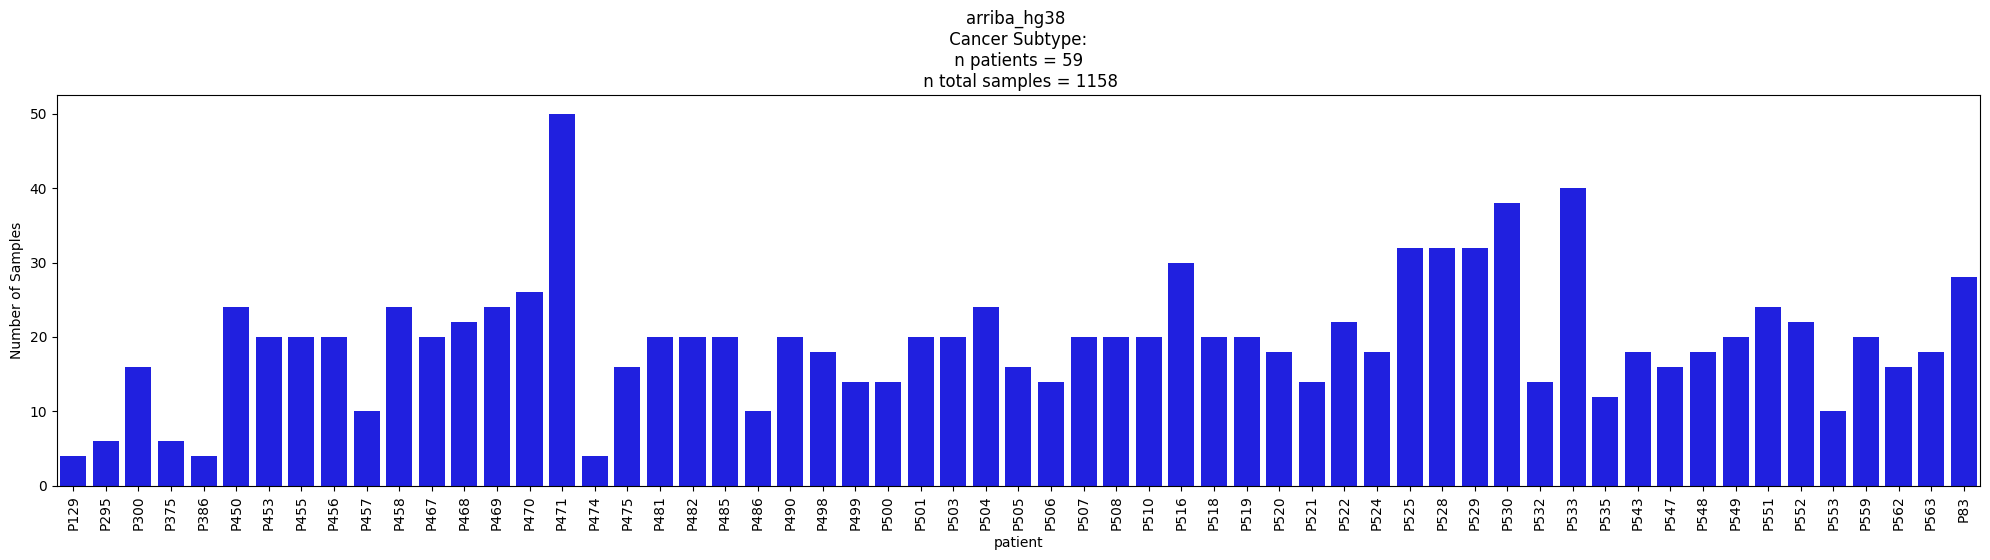

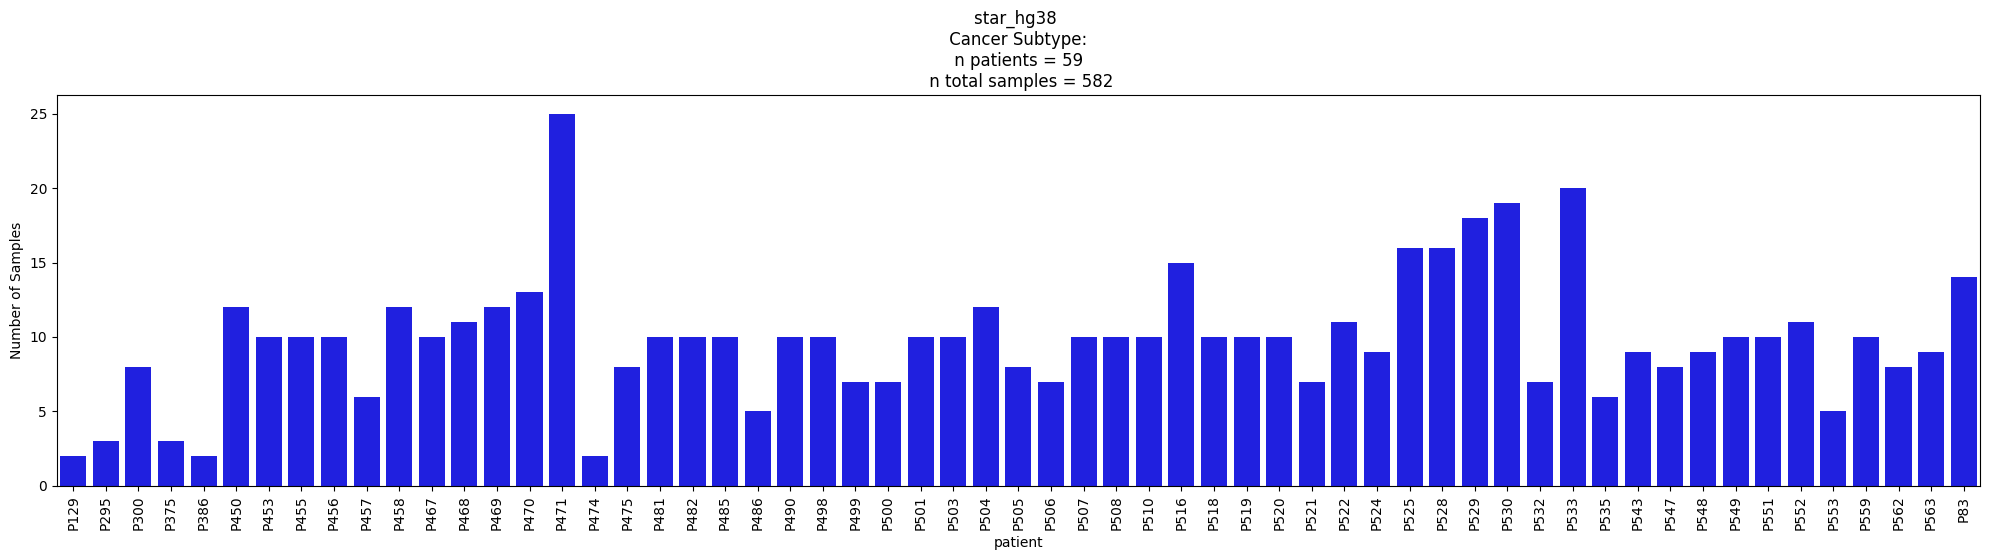

In [44]:
for dt in dfs:

    # fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    plt.subplots(figsize=(20,6))

    # plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    dt_grouped = dfs[dt][['patient', 'file_path']].drop_duplicates().groupby('patient').count().reindex()
    n_patients = dfs[dt]['patient'].nunique()
    n_samples = dfs[dt]['file_path'].nunique()

    dt_grouped = dt_grouped.reset_index()

    sns.barplot(data=dt_grouped, x='patient', y='file_path', color='blue')
    plt.title(f'{dt} \n Cancer Subtype: \n n patients = {n_patients} \n n total samples = {n_samples}')
    plt.xlabel('patient')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation = 90 )
    # plt.xticks(plt.get_xticklabels(), rotation=90)

    # plt.suptitle(f'Number of Samples per patient for Different Cancer Subtypes')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [45]:
gary_table = pd.read_csv('/c4/home/sermare/jupyter-notebooks/Gary_patient_samples.csv', header = 0)

In [46]:
gary_table[(gary_table['SF'].notna()) & (gary_table['SF'].str.contains('SF')) & (gary_table['RNAseq_number'] >= 6) ]['SF'].nunique()

65

In [47]:
purity_estimates = pd.read_csv('/c4/home/sermare/jupyter-notebooks/COSTELLO_PURITY_CONGREGATED.csv')
purity_estimates['Histology'] = purity_estimates['Histology'].astype('str')

In [48]:
# -------------------------------------------------
# 1) Count unique file_paths per patient for each algorithm
# -------------------------------------------------
arriba_counts = (
    arriba38[['patient', 'file_path', 'SF#']]
    .drop_duplicates()
    .groupby(['patient', 'SF#'])
    .size()
    .reset_index(name='count_arriba')
)

star_counts = (
    star38[['patient', 'file_path', 'SF#']]
    .drop_duplicates()
    .groupby(['patient', 'SF#'])
    .size()
    .reset_index(name='count_star')
)

# -------------------------------------------------
# 2) Merge both counts so each patient has Arriba and STAR in the same row
# -------------------------------------------------
merged_counts = pd.merge(
    arriba_counts, 
    star_counts, 
    on='SF#', 
    how='outer'
).fillna(0)


# Convert counts to integers (in case they become float due to fillna)
merged_counts['count_arriba'] = merged_counts['count_arriba'].astype(int)
merged_counts['count_star']   = merged_counts['count_star'].astype(int)

# Sort by patient to create consistent chunks
merged_counts = merged_counts.sort_values(by='SF#', ascending=True).reset_index(drop=True)

merged_counts = pd.merge(left = merged_counts, right = gary_table, left_on = 'SF#', right_on='SF', how = 'inner')


In [49]:
merged_counts['name'] = merged_counts['patient_x'].astype('str') + ' ' + merged_counts['SF'].astype('str')
merged_counts = merged_counts.sort_values(by='Patient')
merged_counts.loc[merged_counts['Patient'] == 'P516', 'RNAseq_number'] = 15

In [50]:
merged_counts = merged_counts[merged_counts['RNAseq_number'] >= 6]

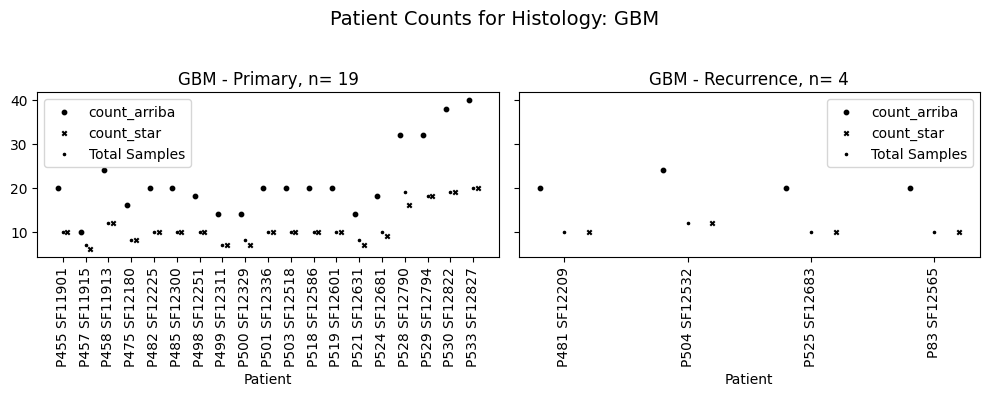

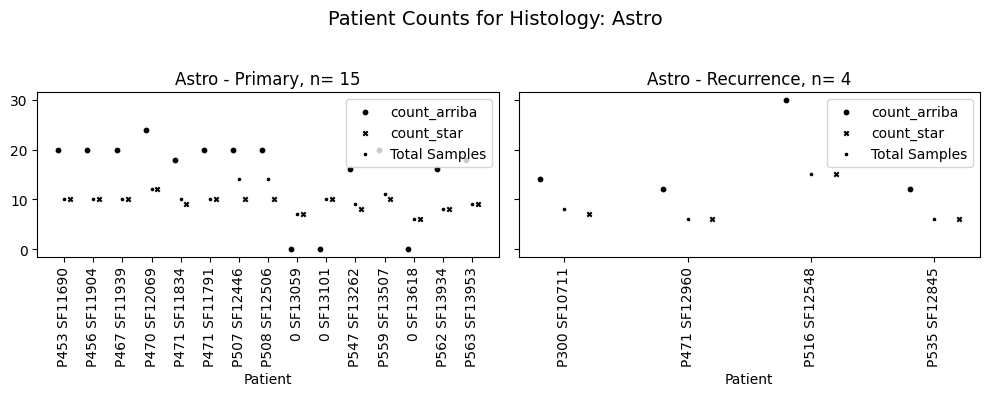

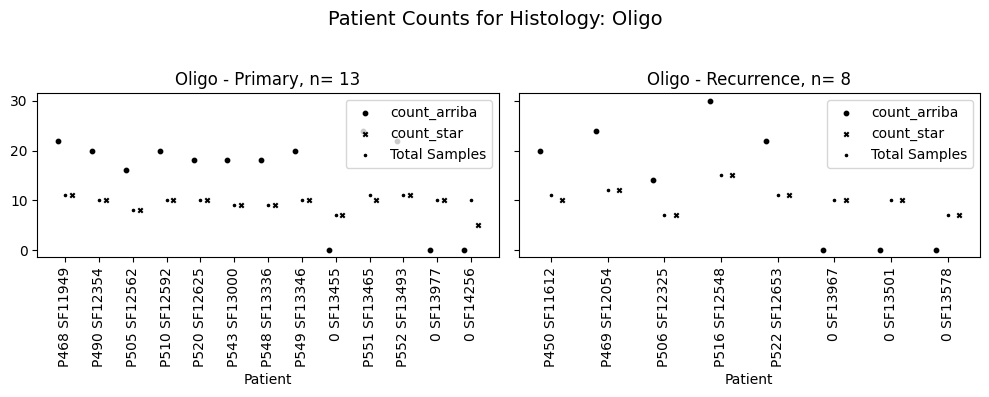

In [51]:
histologies = ['GBM', 'Astro', 'Oligo']

for hist in histologies:
    # First filter for the histology group
    subset = merged_counts[merged_counts['Histology'].str.contains(hist, case=False, na=False)]
    
    # Now separate into primary (no 'recurrece') and recurrence (contains 'recurrece')
    subset_primary = subset[~subset['Tumor'].str.contains('Rec', case=False, na=False)]
    subset_recur   = subset[ subset['Tumor'].str.contains('Rec', case=False, na=False)]
    
    # Create a figure with two subplots (side by side)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    
    for ax, data, label in zip(axes, 
                               [subset_primary, subset_recur], 
                               ['Primary', 'Recurrence']):
        if data.empty:
            ax.set_title(f'{hist} - {label}\n(No data available)')
            ax.set_xlabel('Patient')
            ax.set_ylabel('Count')
            continue
        
        # Create x-axis positions for each patient
        x = np.arange(len(data))
        offset = 0.2  # offset for side-by-side markers
        
        # Plot the data using different markers for each count
        ax.scatter(x - offset, data['count_arriba'], marker='o', color='black', s=10, label='count_arriba')
        ax.scatter(x + offset, data['count_star'], marker='x', color='black', s=10, label='count_star')
        ax.scatter(x, data['RNAseq_number'], marker='.', color='black', s=10, label='Total Samples')
        
        # Set the x-axis labels as patient IDs and add titles/labels
        ax.set_xticks(x)
        ax.set_xticklabels(data['name'], rotation=90)
        ax.set_xlabel('Patient')
        ax.set_title(f'{hist} - {label}, n= {len(data)}')
        ax.legend()
    
    fig.suptitle(f'Patient Counts for Histology: {hist}', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


51 Done patients
9 Half Done patients
51 Total patients


<AxesSubplot: >

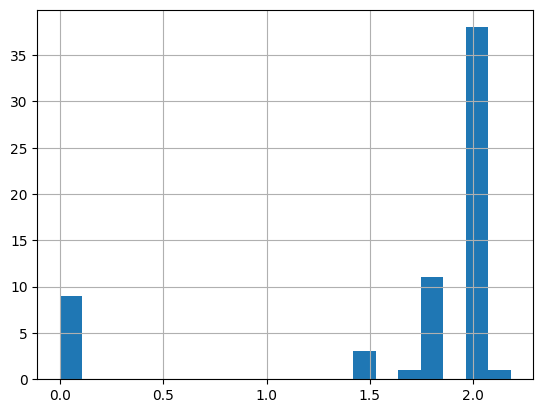

In [52]:
merged_counts['percentage_done'] = merged_counts['count_arriba'] / merged_counts['RNAseq_number']
print(merged_counts[merged_counts['percentage_done'] >= 1]['Patient'].nunique(), "Done patients")
print(merged_counts[merged_counts['percentage_done'] < 0.6]['Patient'].nunique(), "Half Done patients")
print(merged_counts[merged_counts['percentage_done'] > 0]['Patient'].nunique(), "Total patients")
merged_counts['percentage_done'].hist(bins = 20)

47
1 Half Done patients
60 Total patients


<AxesSubplot: >

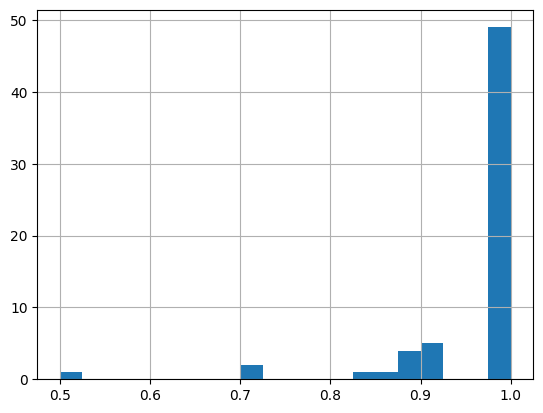

In [53]:
merged_counts['percentage_done'] = merged_counts['count_star'] / merged_counts['RNAseq_number']
print(merged_counts[merged_counts['percentage_done'] >= 1]['Patient'].nunique())
print(merged_counts[merged_counts['percentage_done'] < 0.6]['Patient'].nunique(), "Half Done patients")
print(merged_counts[merged_counts['percentage_done'] > 0]['Patient'].nunique(), "Total patients")
merged_counts['percentage_done'].hist(bins = 20)

In [54]:
merged_counts['percentage_done'] = merged_counts['count_star'] / merged_counts['RNAseq_number']
merged_counts['completed'] = merged_counts['percentage_done'] == 1

In [55]:
# ** maybe redo 503, 506, 

In [56]:
star38['LeftBreakpoint'] = star38['LeftBreakpoint'].str.replace(':-','', regex = False).str.replace(':+','',regex = False)
star38['RightBreakpoint'] = star38['RightBreakpoint'].str.replace(':-','', regex = False).str.replace(':+','', regex = False)
star38['fg_bk'] = star38['fusion_gene'] + '_' + star38['LeftBreakpoint'] + '_' + star38['RightBreakpoint']
arriba38['fg_bk'] = arriba38['fusion_gene'] +  '_' + arriba38['breakpoint1'] + '_' + arriba38['breakpoint2']

In [57]:
merged_counts['patient'] = merged_counts['Patient']

In [58]:
arriba38 = arriba38[arriba38['patient'].isin(merged_counts['patient'].unique())]
star38 = star38[star38['patient'].isin(merged_counts['patient'].unique())]

In [59]:
# For STAR:
star_clonal_fusions = star38.groupby(["patient", "fg_bk"]) \
    .filter(lambda x: x["file_path"].nunique() > 1)

# Create a summary: for each patient, get the list of clonal fusions
star_clonal_set = star_clonal_fusions.groupby("patient")["fg_bk"].unique() \
    .reset_index(name="STAR_clonal_fusions")

# For Arriba:
arriba_clonal_fusions = arriba38.groupby(["patient", "fg_bk"]) \
    .filter(lambda x: x["file_path"].nunique() > 1)

arriba_clonal_set = arriba_clonal_fusions.groupby("patient")["fg_bk"].unique() \
    .reset_index(name="Arriba_clonal_fusions")


In [60]:
# For STAR: Get the list of fusions per sample (file_path)
star_sample_fusions = star38.groupby(["patient", "file_path", "SF#"])["fg_bk"].unique() \
    .reset_index(name="fg_bk_list")

# Merge the clonal set information into the per-sample data
star_sample_clonal = star_sample_fusions.merge(star_clonal_set, on="patient", how="left")

# For each sample, count how many of its fusions are in the overall clonal set
star_sample_clonal["STAR_clonal_in_sample"] = star_sample_clonal.apply(
    lambda row: sum(fg in row["STAR_clonal_fusions"] for fg in row["fg_bk_list"]), axis=1
)

# For Arriba: Get the list of fusions per sample (file_path)
arriba_sample_fusions = arriba38.groupby(["patient", "file_path", "SF#"])["fg_bk"].unique() \
    .reset_index(name="fg_bk_list")

arriba_sample_clonal = arriba_sample_fusions.merge(arriba_clonal_set, on="patient", how="left")

arriba_sample_clonal["Arriba_clonal_in_sample"] = arriba_sample_clonal.apply(
    lambda row: sum(fg in row["Arriba_clonal_fusions"] for fg in row["fg_bk_list"]), axis=1
)


In [61]:
# Starting with your patient-level dataframe (this could be per sample or per patient as needed)
final_df = merged_counts[['SF#', 'patient', 'Histology', 'Tumor', 'RNAseq_number']]

# Merge in the STAR unique counts per file_path (from your original code snippet)
final_df = final_df.merge(arriba_sample_clonal[['SF#','file_path','Arriba_clonal_in_sample']], on=[ "SF#"], how="left") \
                   .merge(star_sample_clonal[['SF#','file_path','STAR_clonal_in_sample']], on=["SF#"], how="left") 

In [62]:
final_df['file_path_x'] = final_df['file_path_x'].str.replace('_FUSIONS.TSV','')

/scratch/sermare/ipykernel_2022349/576188988.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  final_df['file_path_x'] = final_df['file_path_x'].str.replace('_FUSIONS.TSV','')


In [63]:
# Re-add patient P568
p568_df = final_df[final_df["patient"] == "P568"]  # Get lost patient row
final_df_filtered = final_df[final_df["file_path_x"] == final_df["file_path_y"]]  # Apply filtering
final_df = pd.concat([final_df_filtered, p568_df]).reset_index(drop=True)  # Re-add P568

# Check final patient count
print("Final unique patients count after re-including P568:", final_df["patient"].nunique())


Final unique patients count after re-including P568: 52


In [64]:
final_df["Tumor"] = ["Recurrence" if "Rec" in x else "Primary" for x in final_df["Tumor"]]

final_df["Histology_Category"] = [
    "Oligo" if "ligo" in x else "GBM" if "GBM" in x else "Astro" if "stro" in x else "GBM"
    for x in final_df["Histology"]
]
final_df['Histology'] = final_df["Histology_Category"]

histology_order = ['GBM', 'Astro', 'Oligo']

# Convert the 'Histology' column to a categorical type with the specified order
final_df['Histology'] = pd.Categorical(final_df['Histology'], categories=histology_order, ordered=True)

# Sort the DataFrame by 'Histology' (following the defined order) and 'Tumor'
final_df = final_df.sort_values(by=['Histology', 'Tumor'])

final_df["Patient"] = final_df['patient']

In [65]:
# Relabel Histology and Histology_Category for v11 to v17 (except v13) to Astro
mask_relabel = final_df['file_path_x'].str.contains(
    r'P516SF12548-v(?:11|12|14|15|16|17)_', regex=True, na=False
)
final_df.loc[mask_relabel, ['Histology']] = 'Astro'

# Remove Oligo calls for patient P516 that are not in v1 to v10 or v13
mask_oligo = (
    (final_df['Histology'] == 'Oligo') &
    (final_df['patient'] == 'P516') &
    ~final_df['file_path_x'].str.contains(
        r'P516SF12548-V(?:1|2|3|4|5|6|7|8|9|10|13)_', regex=True, na=False
    )
)
final_df = final_df[~mask_oligo]

# Remove Astro calls for patient P516 that are in v1 to v10 or v13
mask_astro = (
    (final_df['Histology'] == 'Astro') &
    (final_df['patient'] == 'P516') &
    final_df['file_path_x'].str.contains(
        r'P516SF12548-V(?:1|2|3|4|5|6|7|8|9|10|13)_', regex=True, na=False
    )
)
final_df = final_df[~mask_astro]

# Remove duplicates
final_df = final_df.drop_duplicates()


In [66]:
from fcg.plots import plot_fusion_heatmap

/c4/home/sermare/fusioncharacterization_gliomas/fcg/plots.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.5)


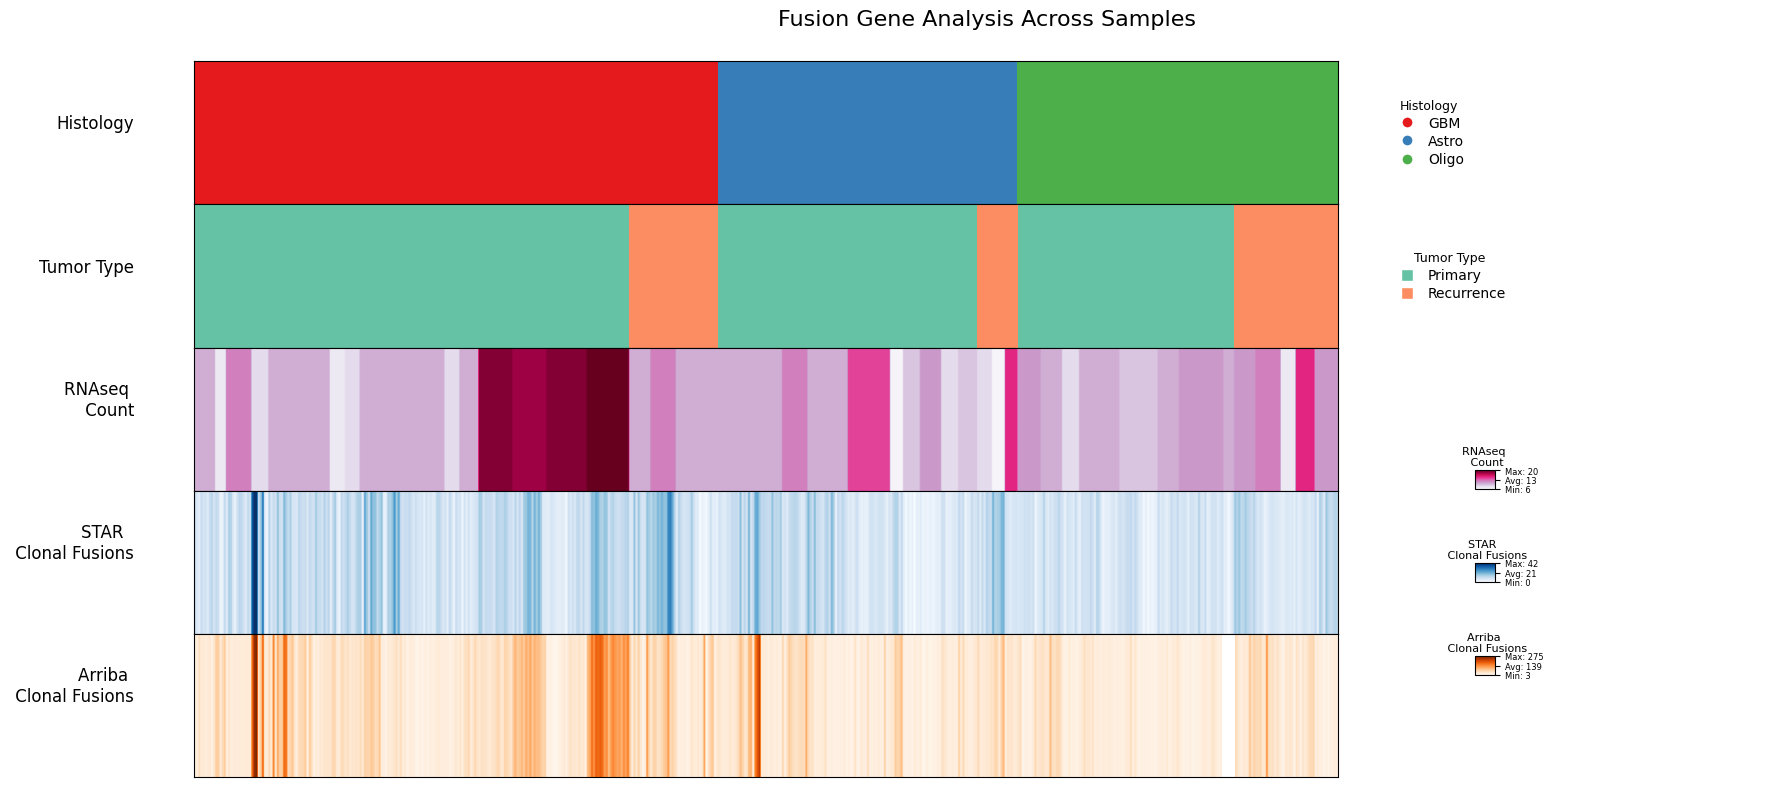

In [67]:
plot_fusion_heatmap(final_df)

In [ ]:
# -----------------------------------------------------------------------
# 2) HELPER: Parse “vX”, “vX-YY”, etc. out of “SF#unique”
# -----------------------------------------------------------------------
def extract_sf_unique_version(sf_unique_str):
    """
    Attempt to capture the chunk immediately after 'SFxxxxx' that starts with 'v'.
    E.g. SF4454v3 -> 'v3'; SF12827-v9-2 -> 'v9-2'; etc.
    Return None if no recognizable pattern is found.
    """
    # We expect something like 'SF1234v5' or 'SF1234-v9-2'
    # so let's remove the initial SF number
    # you could do more advanced logic if your patterns are irregular
    m = re.search(r'^SF\d+(.*)$', sf_unique_str)
    if not m:
        return None
    remainder = m.group(1)
    # e.g. remainder might be 'v3' or '-v9-2'
    # let's capture the "v" plus trailing chars
    m2 = re.search(r'v[0-9A-Za-z-]+', remainder)
    if m2:
        return m2.group(0)  # e.g. 'v3' or 'v9-2' or 'vNMR'
    return None

purity_estimates['version_extracted'] = purity_estimates['SF#unique'].astype('str').apply(extract_sf_unique_version)

# -----------------------------------------------------------------------
# 3) HELPER: Parse version number(s) out of “file_path_x” in final_df
#    e.g. capturing “V3” => “v3” or “V9” => “v9”
# -----------------------------------------------------------------------
def extract_file_path_version(fp):
    """
    Looks for patterns like 'V3', 'V9-2', etc. in file_path.
    We'll capture them as 'v3', 'v9-2', etc. to match the style used in SF#unique.
    """
    # Basic approach: look for 'V' + digits optionally followed by '-digits' etc.
    # e.g. "P533SF12827-V9_S290_" => we want "v9"
    # If you have multiple dashes like "V9-2", you'd handle that as well.
    # Adjust this regex if you have more complicated patterns:
    m = re.search(r'V(\d+(-\d+)?)', fp, flags=re.IGNORECASE)
    if m:
        # group(1) might be e.g. "9", or "9-2", etc.
        return "v" + m.group(1)  # e.g. "v9" or "v9-2"
    else:
        return None

final_df['version_candidate'] = final_df['file_path_y'].apply(extract_file_path_version)

# -----------------------------------------------------------------------
# 4) Construct a “join key” in both DataFrames
#    For final_df, it might be “SF4454v3”.  In purity_estimates, we can just use “SF#unique”.
#    Or we can create a second column "SF# + version_extracted" there, too.
# -----------------------------------------------------------------------

# This approach: final_df’s join_key = SF# + version_candidate, e.g. "SF4454v3"
final_df['join_key'] = final_df['SF#'].astype(str) + final_df['version_candidate'].astype(str)
purity_estimates = purity_estimates[purity_estimates['Patient'] != 'P516']
purity_estimates = purity_estimates[purity_estimates['Patient'] != 'P469']
# Meanwhile we can do the same in purity_estimates, to unify usage:
purity_estimates['join_key'] = purity_estimates['SF#'].astype(str) + purity_estimates['version_extracted'].astype(str)

# -----------------------------------------------------------------------
# 5) Now we can do a left-merge from final_df to purity_estimates
#    on the “join_key” column (plus maybe check that “Patient” lines up)
# -----------------------------------------------------------------------
merged = pd.merge(
    final_df,
    purity_estimates,b
    on='join_key',
    how='left',  # left-merge so all rows from final_df remain
    suffixes=('', '_purity')
)

import numpy as np

# Assume your merged dataframe is called "merged" 
# and has columns: ["Histology", "FACET_purity", "pyClone_purity"].

merged['plot_purity'] = np.where(
    merged['Histology'].isin(['GBM','Oligo']),   # Condition
    merged['FACET_purity'],                      # Value if condition is True
    merged['pyclone.IDH.purity']                     # Value if condition is False (Astro)
)

merged = merged.drop_duplicates()

In [69]:
from fcg.data_utils import process_fusion_purity_data
importlib.reload(data_utils)

<module 'fcg.data_utils' from '/c4/home/sermare/fusioncharacterization_gliomas/fcg/data_utils.py'>

In [70]:
merged = process_fusion_purity_data(final_df, purity_estimates)

In [71]:
from fcg import plots
importlib.reload(plots)

<module 'fcg.plots' from '/c4/home/sermare/fusioncharacterization_gliomas/fcg/plots.py'>

/c4/home/sermare/fusioncharacterization_gliomas/fcg/plots.py:836: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2.0)


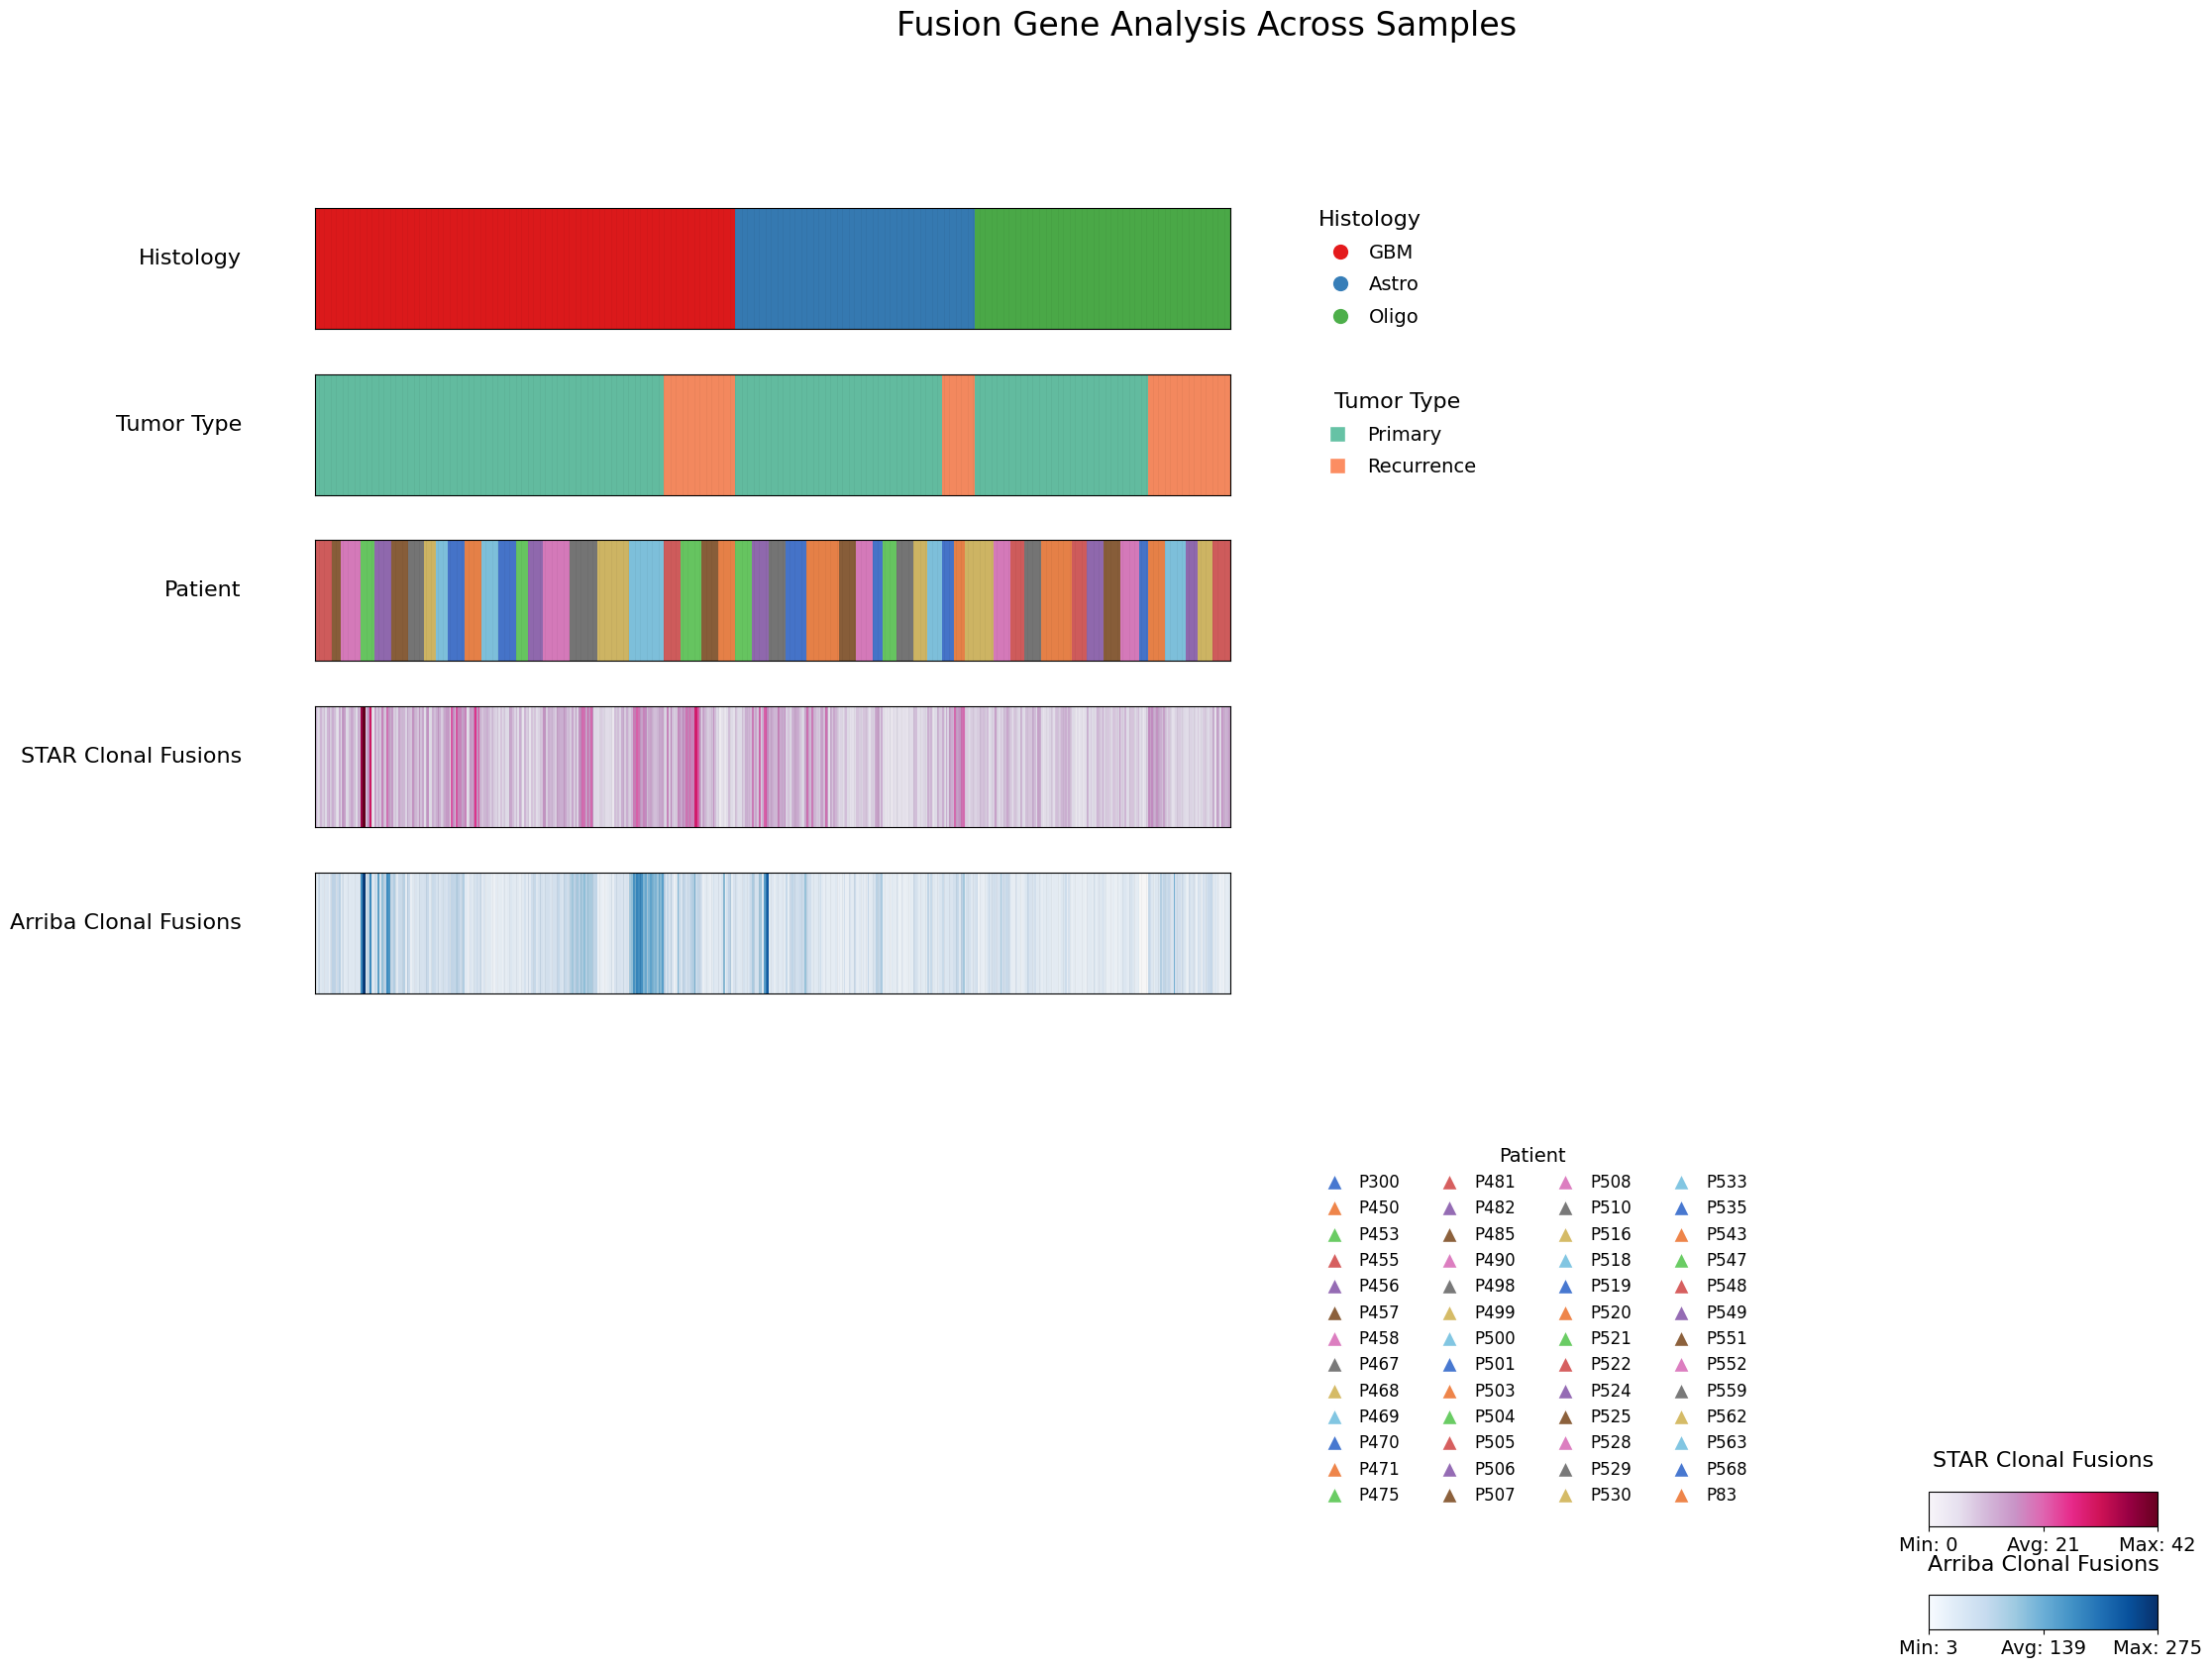

In [72]:
plots.plot_fusion_heatmap_with_patients(final_df)